In [1]:
!pip3 install albumentations pycocotools tqdm

     |████████████████████████████████| 72 kB 1.8 MB/s eta 0:00:011
     |████████████████████████████████| 73 kB 4.4 MB/s  eta 0:00:01
     |████████████████████████████████| 37.6 MB 13.7 MB/s eta 0:00:01
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=319779 sha256=b941cd814ff40737b1c538f83848bd4d2f8f6242dd56abf10ead16e0047e7290
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools


In [1]:
import os

In [2]:
os.chdir('../..')

In [3]:
import sys

In [4]:
sys.path.append('inspiration/ScaledYOLOv4_tensorflow2')

# Loading image

In [5]:
import numpy as np

In [6]:
import PIL
from PIL import Image

In [7]:
os.listdir('data/output/tests/augmented_covers/')[0]

'Travel-Holiday-Guides_0000983_8_188_131_365_141_163_359_322_363.jpg'

In [8]:
augmented_img_output_path = 'data/output/tests/augmented_covers/' + os.listdir('data/output/tests/augmented_covers/')[0]

In [9]:
file_path = augmented_img_output_path
file_path.split('/')[-1].split('.')[0].split('_')[-8:]

['188', '131', '365', '141', '163', '359', '322', '363']

In [10]:
points = np.array(file_path.split('/')[-1].split('.')[0].split('_')[-8:]).reshape((4, 2)).astype(np.int)
points

array([[188, 131],
       [365, 141],
       [163, 359],
       [322, 363]])

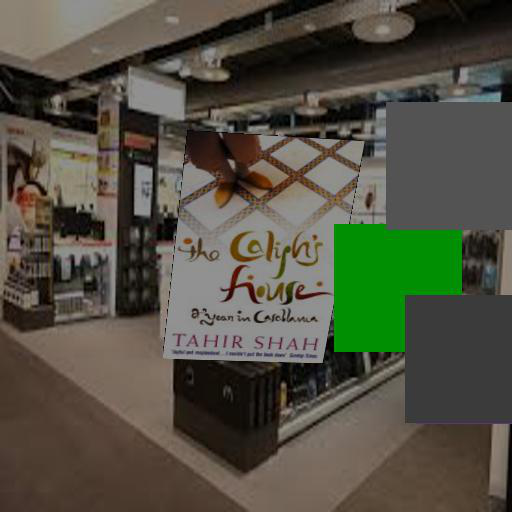

In [11]:
img = Image.open(augmented_img_output_path)
img

In [12]:
img_array = np.array(img.resize((416, 416)))
img_array.shape

(416, 416, 3)

In [13]:
img_array_batch = np.expand_dims(img_array, 0)
img_array_batch.shape

(1, 416, 416, 3)

# Switching_head

In [21]:
import tensorflow as tf

import detect as d
import train as t

In [14]:
from importlib import reload

In [17]:
reload(m_a)

NameError: name 'm_a' is not defined

In [5]:
from dev.python.Yolo import model_architecture as m_a

In [31]:
args = t.parse_args(['--model-type', 'tiny', '--dataset-type', 'voc', '--dataset', 'inspiration/ScaledYOLOv4_tensorflow2/dataset/pothole_voc', '--num-classes', '1', '--class-names', 'pothole.names', '--voc-train-set', 'dataset_1,train', '--voc-val-set', 'dataset_1,val', '--epochs', '200', '--batch_size', '32', '--multi-scale', '416', '--augment', 'ssd_random_crop'])

In [34]:
model = m_a.Yolov4_tiny(args, training=False)

In [25]:
x = model.predict(img_array_batch)
x

(array([[0.99490213, 0.17458236, 0.43868667, 0.9852313 , 0.8851252 ,
         0.00453877, 0.2636614 , 0.34041226, 0.04397038]], dtype=float32),
 array([[0.51270676, 0.14598283, 0.8049641 , 0.165977  , 0.7340474 ,
         0.6357975 , 0.41008997, 0.09377018, 0.0815382 ]], dtype=float32))

# Test train.py

In [11]:
import dev.python.Yolo.train as t

In [13]:
from dev.python.Yolo import model_architecture as m_a

In [25]:
reload(t)

<module 'dev.python.Yolo.train' from '/home/app/dev/python/Yolo/train.py'>

In [12]:
args = t.parse_args(['--epochs', '200', '--batch_size', '4', '--multi-scale', '416'])

In [14]:
model = m_a.Yolov4_tiny(args, training=True)

In [15]:
import tensorflow as tf

In [16]:
t.train_model(model, tf.keras.losses.BinaryCrossentropy(), nb_epoch=20, batch_size=args.batch_size)

0 0
0 1
0 2
0 3
0 4
0 5
0 6


KeyboardInterrupt: 

# Eval

# Split training/eval DS

In [30]:
import random

In [31]:
file_dir = 'data/output/tests/augmented_covers/'

In [32]:
file_list = os.listdir(file_dir)
nb_obs = len(file_list)
nb_obs

325811

In [33]:
index_split = int((nb_obs*0.8//64+1)*64)
index_split

260672

In [34]:
index_array = np.array([i for i in range(nb_obs)])

In [35]:
random.shuffle(index_array)

In [36]:
index_train, index_test = index_array[:index_split], index_array[index_split:]
index_train.shape, index_test.shape

((260672,), (65139,))

In [37]:
index_batch_train = index_train.reshape((index_split//64, 64))
index_batch_train.shape

(4073, 64)

# Training

In [38]:
index_batch_train[0]

array([ 73521, 270383, 323740, 231069, 190795, 145222,  38665, 256366,
       263731, 115442,  26050, 322064,  74145, 314836,  57938, 213674,
        88978,  50354, 176644,  82409, 198831, 256947,  96026,  14163,
       147708, 188856,  69185,  29493, 137853, 306486, 202604, 178275,
       179439, 271349, 297970, 173407, 263598, 106601, 224704, 158890,
        14002, 110739,  63257, 216719, 209203, 260957, 236134, 289522,
       180416, 261705,  73053, 109475, 134916, 190155, 296247, 311155,
        27527, 109288, 277069, 236774, 315081, 274635,  36587,  91616])

In [39]:
[file_list[index]for index in index_batch_train[0]]

['Society-Social-Sciences_0000548_3_170_97_360_129_113_374_283_384.jpg',
 'Crafts-Hobbies_0000613_1_278_56_323_186_122_355_249_394.jpg',
 'Art-Photography_0000202_6_102_111_437_139_83_337_391_359.jpg',
 'Food-Drink_0000593_1_202_26_507_127_84_312_312_353.jpg',
 'Home-Garden_0000681_6_274_31_396_163_57_429_255_407.jpg',
 'Personal-Development_0000283_1_164_161_317_101_161_387_312_327.jpg',
 'Technology-Engineering_0000092_5_188_103_379_149_119_342_275_363.jpg',
 'Dictionaries-Languages_0000028_8_174_106_412_154_94_392_301_394.jpg',
 'Crime-Thriller_0000295_5_261_-8_433_131_40_340_228_389.jpg',
 'Religion_0000307_9_311_57_429_166_113_299_245_328.jpg',
 'Teen-Young-Adult_0000372_5_140_94_409_79_129_379_385_362.jpg',
 'Art-Photography_0000383_0_198_76_425_173_85_353_280_415.jpg',
 'Society-Social-Sciences_0000493_1_190_132_338_130_169_432_312_410.jpg',
 'Biography_0000112_6_292_30_408_150_83_333_234_362.jpg',
 'Stationery_0000124_8_249_66_486_189_104_341_300_403.jpg',
 'Health_0000371_8_20

In [40]:
model = m_a.Yolov4_tiny(args, training=True)

In [44]:
def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)

    return l(y_true=y, y_pred=y_)

In [45]:
def grad(model, inputs, targets, training):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=training)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [46]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [47]:
l = tf.keras.losses.BinaryCrossentropy()
for epoch in range(1):
    for index_batch in index_batch_train[:1]:
        img_batch = []
        label_batch = []
        for index in index_batch:
            filename = file_list[index]
            # les coord ne sont plus bonnes dans l'image resized
            img_batch.append(np.array(Image.open(file_dir+filename).resize((512,512))))

            points = np.array(filename.split('.')[0].split('_')[-8:]).reshape((4, 2)).astype(np.int)
            label_batch.append(np.concatenate((np.concatenate(np.array(list(zip(points[:,0]/img_array.shape[0], points[:,1]/img_array.shape[1])))), np.array([1]))))

        img_batch_array = np.stack(img_batch)
        label_batch_array = np.stack(label_batch)

        loss_value, grads = grad(model, img_batch_array, label_batch_array, training=True)

        optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [74]:
l = tf.keras.losses.BinaryCrossentropy()

In [87]:
l(label_batch_array, output[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.69735116>

In [93]:
loss(model, img_batch_array, label_batch_array, training=True)

<tf.Tensor: shape=(), dtype=float32, numpy=0.832626>

In [107]:
grad(model, img_batch_array, label_batch_array, training=True)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.832626>,
 [<tf.Tensor: shape=(3, 3, 3, 32), dtype=float32, numpy=
  array([[[[-6.44241087e-03,  4.22888011e-01,  1.68672623e-03,
             1.02006674e-01,  4.12684446e-03,  2.12778486e-02,
             1.90163493e-01,  1.89719573e-02,  7.90690072e-03,
            -4.54684868e-02, -4.29890454e-02,  4.51114997e-02,
             8.95615947e-03, -1.36810876e-02, -9.36431512e-02,
            -2.35064346e-02,  3.74979638e-02,  4.13927622e-02,
             5.24369348e-03, -5.09801880e-03, -2.42665168e-02,
             2.63544358e-03,  1.41509548e-01, -2.42191121e-01,
             1.00604966e-02,  1.57858692e-02,  1.51858665e-04,
             7.01229721e-02, -5.29344101e-03,  2.00880170e-02,
             7.86964446e-02, -4.26323041e-02],
           [-1.95659865e-02,  1.40011653e-01,  1.00559732e-02,
             1.40072867e-01, -6.63183304e-03,  1.14184665e-03,
             1.50366381e-01,  1.03150913e-02, -2.04166025e-02,
            -2.9150219

In [110]:
loss_value, grads = grad(model, img_batch_array, label_batch_array, training=True)

optimizer.apply_gradients(zip(grads, model.trainable_variables))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [58]:
img_batch_array.shape, label_batch_array.shape

((64, 512, 512, 3), (64, 9))

In [43]:
output = model(img_batch_array)
output[0].shape

TensorShape([64, 9])

In [67]:
loss = tf.keras.losses.BinaryCrossentropy()

In [64]:
l(label_batch_array, output[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.69735116>

In [ ]:
contrainte de la taille de l'image d'entrée Vs variable size of head

In [49]:
model.save('data/model/'+'TinyYolo_%s')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: data/model/TinyYolo/assets
